# Add_feature 1
* 기존변수 + u-g,g-r,r-i,i-z만 추가변수로 사용
* 각 mag에서 max인 filter 변수추가
* category_features 사용위해 lgb.train사용
* 제출결과 : max값 넣은거보다 좋지 않아서 제출패스

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

In [37]:
# from google.colab import drive
# drive.mount('/content/drive')

In [38]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [39]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

## DATA Setting

In [40]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [41]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [7]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [42]:
train_df = add_minus_feature(train_df)
test_df = add_minus_feature(test_df,True)

C:\Users\starl\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


In [49]:
def label_encode(data):
    '''
    각 mag에서 가장 높은값의 filter를 labelencoding 
    '''
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    taget_cols = ['psfMag_MAX','fiberMag_MAX','petroMag_MAX','modelMag_MAX']
    for col in taget_cols:
        data[col] = le.fit_transform(data[col])
    return data

In [50]:
train_df = label_encode(train_df)
test_df = label_encode(test_df)

In [52]:
train_X = train_df.drop(columns=['type', 'type_num'], axis=1)
train_y = train_df['type_num']
test_X = test_df

In [53]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [54]:
train_ds = lgb.Dataset(X_train, label = y_train, categorical_feature=['fiberID'])
test_ds = lgb.Dataset(X_test, label = y_test, categorical_feature=['fiberID']) 

In [55]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},
    'num_leaves': 25,
    'learning_rate': 0.005,
    'max_depth' : 12,
    'random_state' : 42
}

## Modeling

In [56]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 20000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

C:\Users\starl\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	Train's multi_logloss: 1.28403	Test's multi_logloss: 1.30578
[200]	Train's multi_logloss: 0.90101	Test's multi_logloss: 0.936499
[300]	Train's multi_logloss: 0.687275	Test's multi_logloss: 0.734863
[400]	Train's multi_logloss: 0.555221	Test's multi_logloss: 0.61384
[500]	Train's multi_logloss: 0.468923	Test's multi_logloss: 0.539039
[600]	Train's multi_logloss: 0.41059	Test's multi_logloss: 0.491548
[700]	Train's multi_logloss: 0.369557	Test's multi_logloss: 0.460508
[800]	Train's multi_logloss: 0.339141	Test's multi_logloss: 0.440174
[900]	Train's multi_logloss: 0.315484	Test's multi_logloss: 0.426968
[1000]	Train's multi_logloss: 0.296329	Test's multi_logloss: 0.417927
[1100]	Train's multi_logloss: 0.280575	Test's multi_logloss: 0.411813
[1200]	Train's multi_logloss: 0.267077	Test's multi_logloss: 0.407653
[1300]	Train's multi_logloss: 0.255182	Test's multi_logloss: 0.404684
[1400]	Train's multi_logloss: 0.24455	Test

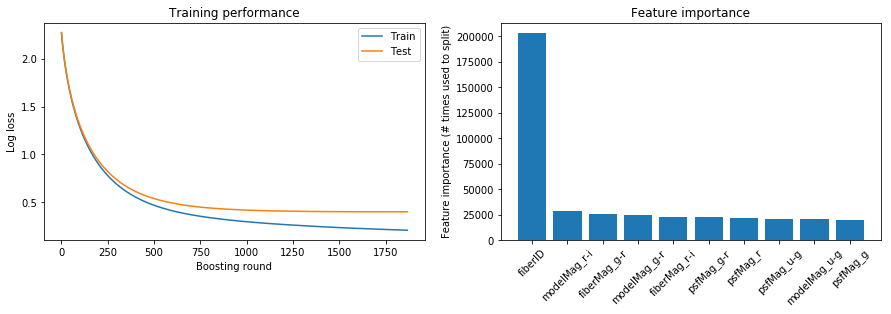

In [57]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [58]:
train_y_pred = lgmb_model.predict(X_test)
real_y_pred = lgmb_model.predict(test_X)

In [59]:
train_y_pred.shape

(59998, 19)

In [60]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.4000156391627351

In [61]:
lgmb_model.feature_importance()

array([203119,  14290,  20053,  21497,  16947,  16946,  12481,  13462,
        16079,  15619,  12226,  11751,   9718,   9831,  14576,  11370,
        12624,  13221,   9258,  11421,  16033,    474,  21137,  22483,
        16767,  16336,   1496,  18927,  25160,  22526,  19898,    949,
        18840,  17598,  15496,  12071,   1032,  20667,  24865,  28555,
        18405])

### feature_importance

In [62]:
pi_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df.head(10)

,importance
fiberID,203119
modelMag_r-i,28555
fiberMag_g-r,25160
modelMag_g-r,24865
fiberMag_r-i,22526
psfMag_g-r,22483
psfMag_r,21497
psfMag_u-g,21137
modelMag_u-g,20667
psfMag_g,20053


### 예측결과에 대해
* 12번이 모두 6번으로 몰림
중간예측 : 0,2,7,11
망한예측 : 12,17

In [63]:
cm_result = pd.DataFrame(confusion_matrix(y_test,np.argmax(train_y_pred,axis = 1)))

In [64]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,232,1,0,0,17,55,4,172,61,0,0,19,0,1,18,10,0,0,58
1,1,1878,0,0,0,1,1,3,17,0,3,4,0,0,0,0,4,0,40
2,0,0,68,73,0,0,0,0,0,0,8,0,0,0,0,0,0,1,0
3,0,0,40,635,0,0,0,0,0,1,93,0,0,0,0,0,0,0,0
4,2,0,0,0,4250,23,0,0,9,0,0,13,0,0,0,89,0,0,0
5,35,1,1,0,153,3633,2,65,55,0,0,5,0,0,0,87,0,0,13
6,4,22,0,0,12,2,10912,4,85,1,0,48,0,83,19,12,0,0,0
7,138,0,0,0,0,196,0,687,21,0,0,2,0,0,0,1,0,0,351
8,10,12,2,6,31,229,120,35,13123,0,13,221,0,74,81,9,14,0,924
9,0,0,0,0,0,0,0,0,9,29,0,0,0,0,0,0,0,0,0


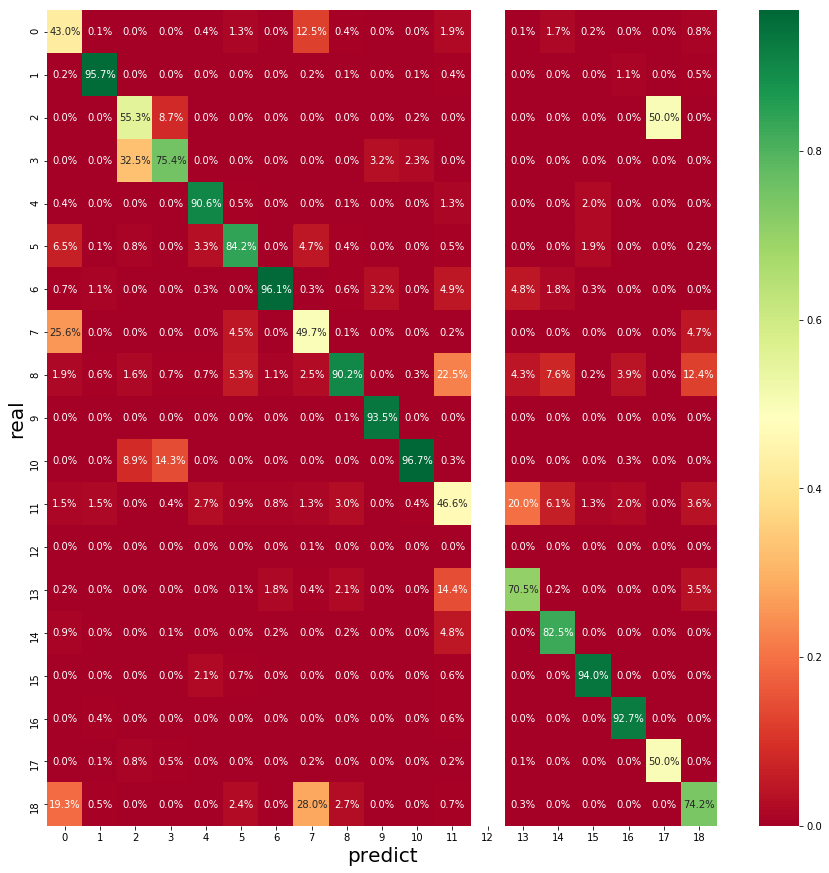

In [65]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [66]:
train_ds = lgb.Dataset(train_X, label = train_y, categorical_feature=['fiberID'])

In [67]:
lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, verbose_eval=100)

C:\Users\starl\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [68]:
y_pred = lgmb_model.predict(test_X)

In [69]:
y_pred

array([[2.07696458e-05, 5.55002287e-05, 5.43184731e-05, ...,
        1.11824735e-05, 1.45095108e-06, 1.80332167e-04],
       [1.86990100e-04, 4.20041197e-04, 2.89275442e-05, ...,
        6.57337611e-05, 7.43639182e-06, 1.63780030e-03],
       [8.73536006e-05, 2.50594345e-05, 1.36695211e-06, ...,
        3.08218394e-06, 3.91211796e-07, 7.07185591e-05],
       ...,
       [2.13176747e-04, 3.89932462e-04, 1.92144280e-05, ...,
        4.33244155e-05, 4.94959150e-06, 7.19348271e-02],
       [4.53366666e-06, 1.03941801e-05, 6.84881527e-07, ...,
        1.54426101e-06, 1.78734185e-07, 3.18433331e-04],
       [3.77150484e-04, 7.69056250e-06, 4.73892562e-07, ...,
        1.06852613e-06, 1.22434907e-07, 4.11619367e-05]])

In [70]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)